In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Impute missing values in 'value' and 'classification_numerical' columns
imputer = SimpleImputer(strategy='mean')
X_train[['value', 'classification_numerical']] = imputer.fit_transform(X_train[['value', 'classification_numerical']])

# Verify that there are no NaN values left
print("NaN values in X_train after imputation:\n", X_train.isna().sum().sum())

# Check for extreme values in the data
print("Extreme values in X_train:", (X_train > 1e9).sum().sum())

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns  # All columns in X_train are numerical

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features
X_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


NaN values in X_train after imputation:
 0
Extreme values in X_train: 2367


## Function to save models for later

In [8]:
def save_model_and_scalers(model, scaler_X, scaler_y, model_type):
    """
    Save the Keras model and scalers with a timestamp and type in a directory using pickle.

    Parameters:
    - model: The trained Keras model to be saved.
    - scaler_X: The MinMaxScaler object for the features.
    - scaler_y: The MinMaxScaler object for the target variable.
    - model_type: A string representing the type of the model (e.g., "RNN", "LSTM").
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"saved_models/{model_type}"  # Create a directory with the model name
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_filename = f"{save_dir}/{model_type}_model_{timestamp}.h5"
    model.save(model_filename)

    # Save the scalers
    scalers_filename = f"{save_dir}/{model_type}_scalers_{timestamp}.pkl"
    with open(scalers_filename, 'wb') as f:
        pickle.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, f)

    print(f"Model saved to {model_filename}")
    print(f"Scalers saved to {scalers_filename}")

## SimpleRNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam


# Reshape the input data to 3D as required by RNN (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Defining the model
model = Sequential([
    SimpleRNN(50, input_shape=(1, X_train_scaled.shape[1])),  # 50 RNN units
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=3, validation_split=0.2)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Save the RNN model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "RNN")

(test_loss, history.history)

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         4,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,401 (17.19 KB)

 Trainable params: 4,401 (17.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1237 - val_loss: 0.2628
Epoch 2/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.0126 - val_loss: 0.1193
Epoch 3/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.0053 - val_loss: 0.0500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.0202


Model saved to saved_models/RNN_model_20240601_233855.h5
Scalers saved to saved_models/RNN_scalers_20240601_233855.pkl


(0.017152419313788414,
 {'loss': [0.057590339332818985, 0.010137427598237991, 0.004679815378040075],
  'val_loss': [0.26275455951690674, 0.11925950646400452, 0.04998309910297394]})

# LSTM Implementation

In [11]:
# Example usage with the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=5, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Save the LSTM model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "LSTM")

print(f"Test Loss: {test_loss}")

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0182
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.0020 - val_loss: 0.0108
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.0020 - val_loss: 0.0103
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.0014 - val_loss: 0.0106
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0012 - val_loss: 0.0157
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.0136


Model saved to saved_models/LSTM/LSTM_model_20240601_234358.h5
Scalers saved to saved_models/LSTM/LSTM_scalers_20240601_234358.pkl
Test Loss: 0.00884193554520607


# GRU Implementation

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Input layer is inferred from the input_shape in the first layer
    GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=5, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Save the LSTM model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "GRU")

print(f"Test Loss: {test_loss}")


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - val_loss: 0.0160
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0025 - val_loss: 0.0156
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0019 - val_loss: 0.0125
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0017 - val_loss: 0.0259
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0014 - val_loss: 0.0116
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - loss: 0.0172


Model saved to saved_models/GRU/GRU_model_20240601_234548.h5
Scalers saved to saved_models/GRU/GRU_scalers_20240601_234548.pkl
Test Loss: 0.011548779904842377


**Recommendation:**  
Given the observed performances, the LSTM model appears to be more suitable for our dataset and task. It generalizes better to unseen data, as evidenced by the lower test loss. Pursuing the LSTM model in more detail could involve:

- **Hyperparameter Tuning:** Experiment with different numbers of units in the LSTM layers, learning rates, and batch sizes.
- **Model Complexity:** Try adding more LSTM layers or adjusting the dropout rates to see if the model's generalization capability can be improved further.
- **Regularization Techniques:** Beyond dropout, consider trying other regularization techniques like L1/L2 regularization on the LSTM layers to control overfitting.
- **Early Stopping:** Implement early stopping during training to stop the training process when the validation loss stops decreasing, helping prevent overfitting.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Data reshaping for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model definition
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Model summary
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=10, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Save the LSTM model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "Sequential")

print(f"Test Loss: {test_loss}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,201 (157.04 KB)

 Trainable params: 40,201 (157.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0194
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0022 - val_loss: 0.0139
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.0014 - val_loss: 0.0121
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0014 - val_loss: 0.0124
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0013 - val_loss: 0.0093
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 9.9437e-04 - val_loss: 0.0095
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 8.2707e-04 - val_loss: 0.0069
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 6.9098e-04 - val_loss: 0.0040
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8027e-04 - val_loss: 0.0038
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 5.9413e-04 - val_loss: 0.0027
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 0.0121


Model saved to saved_models/Sequential/Sequential_model_20240601_234608.h5
Scalers saved to saved_models/Sequential/Sequential_scalers_20240601_234608.pkl
Test Loss: 0.009227076545357704


## Adding TimeseriesGenerator

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_input = 168  # The number of time steps to look back for predictions
n_features = X_train_scaled.shape[1]  # The number of features in the dataset

# Create the TimeseriesGenerator for training and validation sets
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=64)
validation_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_input, batch_size=64)

# Define the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Save the LSTM model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "LSTM")

# Make predictions
y_pred_scaled = model.predict(validation_generator)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate the model
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

Epoch 1/10


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 4/35 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0098

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0381 - val_loss: 0.0255
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0118 - val_loss: 0.0053
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0082 - val_loss: 0.0040
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0044 - val_loss: 0.0082


Model saved to saved_models/LSTM/LSTM_model_20240601_234937.h5
Scalers saved to saved_models/LSTM/LSTM_scalers_20240601_234937.pkl
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Mean Squared Error: 23396414.78985638
Mean Absolute Error: 4152.322216428361
R-squared Score: -0.1527878542386616


In [19]:
import pandas as pd

# Recreate the datetime column from the index (assuming the index was a datetime index)
if 'datetime' not in X_test.columns:
    X_test['datetime'] = pd.to_datetime(X_test.index)

print("Available columns in X_test after adding datetime:", X_test.columns)


Available columns in X_test after adding datetime: Index(['open', 'volume', 'sma_30', 'rsi', 'macd', 'dia_close', 'dia_volume',
       'gld_close', 'gld_volume', 'spy_close', 'spy_volume',
       'federal_funds_rate_daily', 'treasury_yield_daily', 'cpi_monthly',
       'durables_monthly', 'nonfarm_payroll_monthly',
       'real_gdp_per_capita_quarterly', 'real_gdp_quarterly',
       'retail_sales_monthly', 'unemployment_monthly',
       'central_bank_policy_rate_prcnt', 'domestic_credit_gdp',
       'foreign_direct_investment_value', 'gdp_growth_annual_prcnt',
       'inflation_rate_value',
       'individuals_using_the_internet_prcnt_of_population',
       'mobile_cellular_subscriptions_per_100_people',
       'personal_remittances_received_prcnt_of_gdp',
       'stock_market_index_value', 'tariffs_value',
       'total_public_debt_gdp_value', 'trade_balance_value',
       'trade_in_services_value', 'unemployment_rate_value', 'value',
       'classification_numerical', 'datetime'],
  

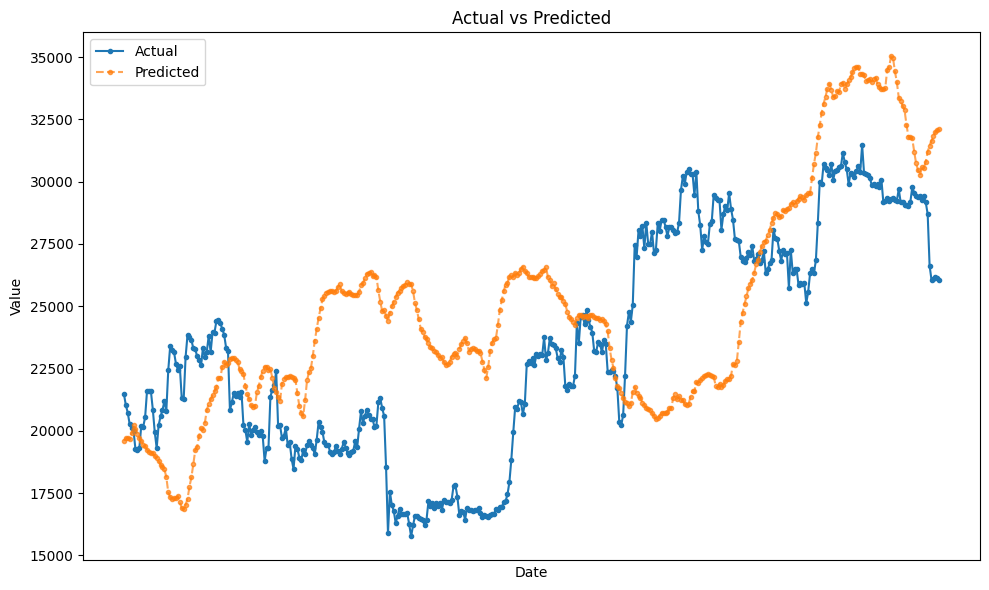

In [20]:
import matplotlib.pyplot as plt

# Align the test dates with the predictions
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

# Visualization with actual datetime on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-')
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()
